## **Unsupervised ML approach to cluster mental health cases**
This uses an unsupervised ML approach to dentifying mental health cases related to the climate variables (q, t2m, and uvbed(UV) and associated thresholds leading to these events.

Note: Many health conditions are shaped by factors beyond climate -- such as genetics, lifestyle, socio-economic status, and healthcare access--making it difficult to isolate climate as the primary influence in many clinical cases.

In [1]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

### 1. Data Loading and Preprocessing

#### Read Data

In [2]:
#### read the climate_health data
df = pd.read_csv(
    "dataset/health_climate_2018_2020.csv", 
    parse_dates=["incident_time"]
)

#### Compute temporal features

In [3]:
# compute temporal features based on incident_time
# Seasonality = patterns that repeat over a known cycle, usually time-based. For climate
def get_days_in_year(year):
    return 366 if calendar.isleap(year) else 365
        
def temporal_cyclical_features(df, time_col='incident_time'):
    df = df.copy()

    # Convert the time column to datetime if not already
    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col])

    # Extract temporal features
    df['DayOfYear'] = df[time_col].dt.dayofyear                 # Day of the year (1-365/366)
    df['Month'] = df[time_col].dt.month                         # Month of the year (1-12)
    df['WeekOfYear'] = df[time_col].dt.isocalendar().week
    df['WeekOfYear'] = df['WeekOfYear'].apply(lambda x: x if x <= 52 else 52)  # Handle Week 53 cases by mapping them to 52
 
    # Determine the season (0: Winter, 1: Spring, 2: Summer, 3: Fall)
    df['Season'] = df[time_col].apply(lambda x: 
        0 if x.month in [12, 1, 2] else 
        1 if x.month in [3, 4, 5] else 
        2 if x.month in [6, 7, 8] else 
        3
    )
    return df


df = temporal_cyclical_features(df, time_col='incident_time')

#### Select Required Season
In computing temporal features, summer months are assigned a season value of 2, assuming they represent the warm months.

In [4]:
df = df[df['Season'].isin([1, 2])]  # 1 = spring, 2 = summer

#### Filter Dataset by Mental Health
We need only mental health data so we will select that from the dataset

In [5]:
mh_df = df[df['clinical_category'] == '(Mental Health)']

### Drop NANs
K-Means and XGBoost cannot handle NaNs directly, so we must remove them

In [6]:
mh_df = mh_df.dropna() #Drop Nans

####  Metrics Conversion
Temperature is converted from Kelvin (K) to Celsius (°C) because Celsius is more widely understood and relevant for everyday use. Humidity is converted from kg/kg to g/kg for easier interpretation, as g/kg is a more familiar and practical unit for describing moisture in the air.

In [7]:
mh_df['t2m_c'] = mh_df['t2m'] - 273.15

In [8]:
# Specific humidity in g/kg
mh_df['q_g_kg'] = mh_df['q'] * 1000

#### ONLY Hot Days (Temp > 15°C)
We assume hot days from March to August should have temperatures above 15°C.

In [9]:
# Filter out temperatures below 15°C
mh_df = mh_df[mh_df['t2m_c'] >= 15].copy()

## Unsupervised Learning: SpectralClustering with K-Mean
We apply `SpectralClustering` with `K-Means` to analyse mental health cases, using climate variables (temperature, humidity, UV radiation) to identify meaningful, interpretable clusters for policy insights.

In [10]:
climate_features = ['q', 't2m', 'uvbed']
X = StandardScaler().fit_transform(mh_df[climate_features])

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')
mh_df_cluster = mh_df.copy()
mh_df_cluster.loc[:, 'cluster'] = spectral.fit_predict(X)

### Compute Cluster Summary
This code groups data by `cluster`, calculates counts and means of selected features, and outputs a summary `DataFrame` with `reset_index()` for `cluster`.

In [17]:
# Get summary statistics per cluster, and calculate percentage of total
cluster_summary = mh_df_cluster.groupby('cluster').agg(
    q_mean=('q', 'mean'),
    q_min=('q', 'min'),
    q_max=('q', 'max'),
    q_std=('q', 'std'),
    
    t2m_mean=('t2m', 'mean'),
    t2m_min=('t2m', 'min'),
    t2m_max=('t2m', 'max'),
    t2m_std=('t2m', 'std'),
    
    uvbed_mean=('uvbed', 'mean'),
    uvbed_min=('uvbed', 'min'),
    uvbed_max=('uvbed', 'max'),
    uvbed_std=('uvbed', 'std'),
    
    count=('cluster', 'size')
).reset_index()

# Add percentage of total samples
cluster_summary['% of samples'] = ((cluster_summary['count'] / cluster_summary['count'].sum()) * 100).round(2)

# Optional: drop count column if no longer needed
cluster_summary = cluster_summary.drop(columns=['count'])


In [18]:
cluster_summary

,cluster,q_mean,q_min,q_max,q_std,t2m_mean,t2m_min,t2m_max,t2m_std,uvbed_mean,uvbed_min,uvbed_max,uvbed_std,% of samples
0,0,0.008625,0.003725,0.013605,0.001528,292.695864,288.151367,304.299316,3.048042,0.100275,0.005441,0.198438,0.039958,86.13
1,1,0.008564,0.004442,0.014134,0.001794,292.732908,288.156738,303.197266,3.012658,0.098391,0.007742,0.199968,0.042366,13.19
2,2,0.008496,0.005956,0.011187,0.001302,291.835965,288.255737,297.807861,2.723405,0.074574,0.027269,0.128469,0.029494,0.68


In [14]:
cluster_summary.to_csv('summaries/cluster_summary_spring_summer.csv', index=False)

### Decision Tree to Interprete Subclusters

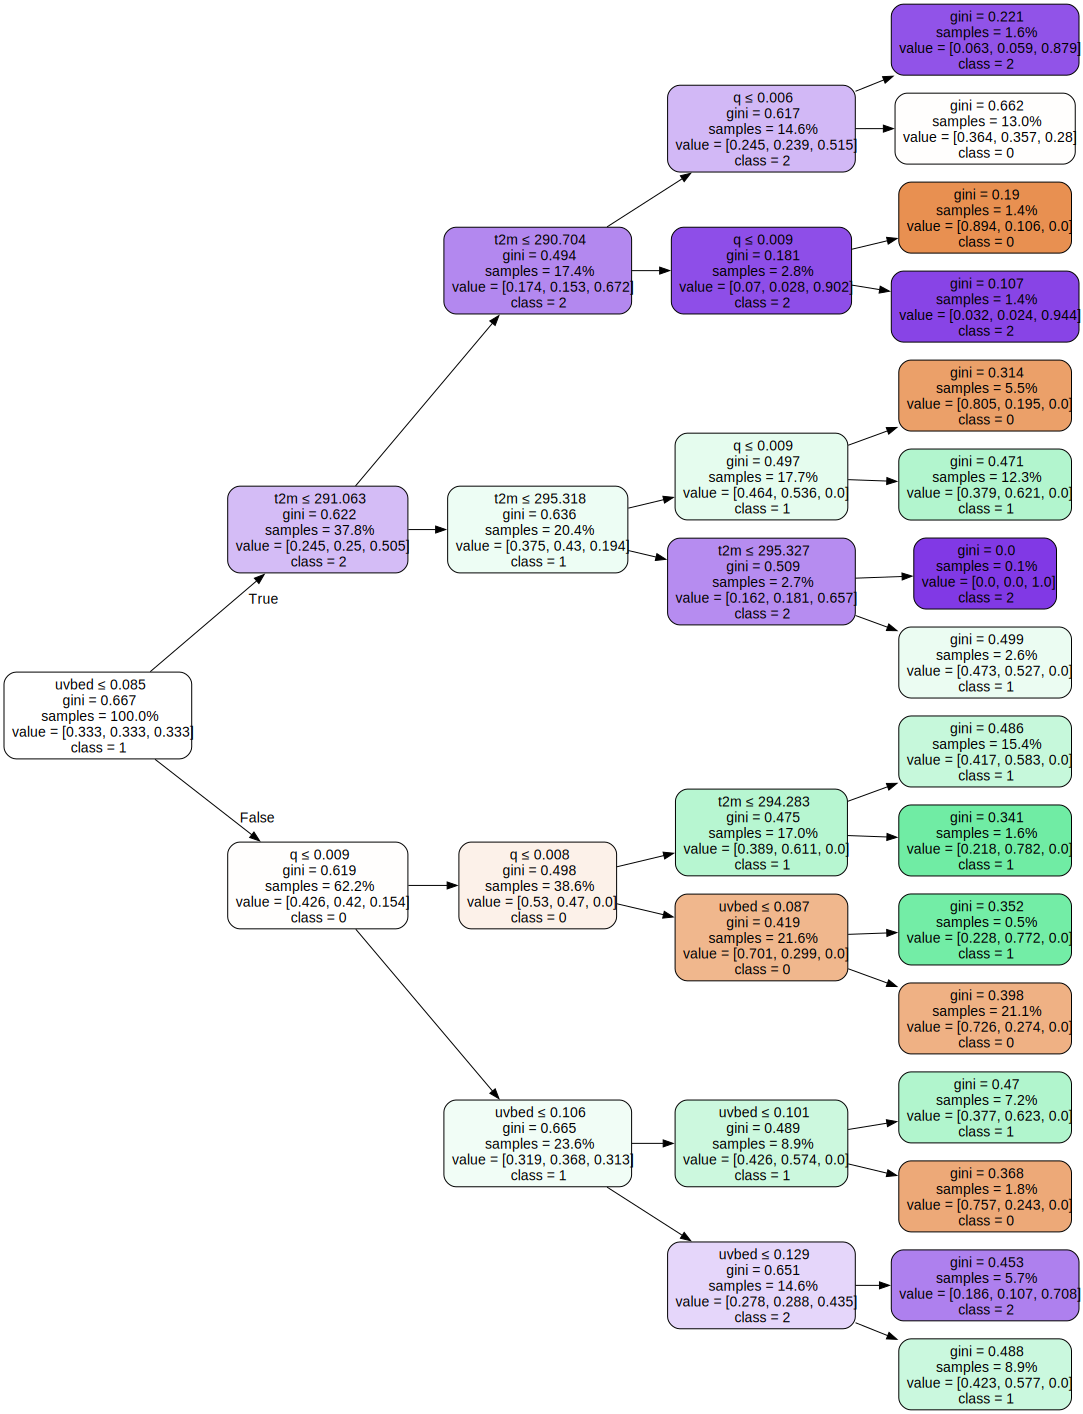

In [13]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import graphviz
from IPython.display import display, SVG
import re

# Encode subclusters
le = LabelEncoder()
mh_df_cluster['cluster_id'] = le.fit_transform(mh_df_cluster['cluster'])

# Train tree
X = mh_df_cluster[['q', 't2m', 'uvbed']]
y = mh_df_cluster['cluster_id']
tree = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=0)
tree.fit(X, y)

# Export DOT data
dot_data = export_graphviz(tree, 
                           feature_names=X.columns, 
                           class_names=le.classes_.astype(str).tolist(),  # Fix here
                           filled=True, 
                           rounded=True, 
                           special_characters=True, 
                           proportion=True)

# Inject horizontal layout
dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\nrankdir=LR;')

# Remove all occurrences of 'value = [..]' in node labels
dot_data = re.sub(r'value = \[.*?\]\\n', '', dot_data)

# Create Graphviz source and render as SVG
graph = graphviz.Source(dot_data, format="svg")
svg = graph.pipe().decode('utf-8')

# Display inline in JupyterLab
display(SVG(svg))
